# Analyze Tadpole Footage Output Data from Trex and Identify Collisions

#### About
This notebook takes output data from the [Trex](https://github.com/mooch443/trex) compute vision tool and runs exploratory data analysis on the information provided for each tadpole and builds datasets of tadpoles positions and pairwise collisions.  The notebook also plots the positions of a few sample tadpoles as well as the positions for all pairwise collisions.

#### Parameters
There are two main parameters for this analysis:

- `TREX_OUTPUT_DATA_PATH` controls the location of the input data consisting of `.npz` files from Trex.
- `COLLISION_THRESHOLD` controls what we consider to be a collision between tadpoles.  If the L2 norm (euclidean distance) between tadpole X and Y positions in the footage is less than `COLLISION_THRESHOLD`, we mark a collision.

See the README in this repo for more information about applying this analysis to other video footage.

#### References
Tadpole footage comes from [Levin lab](https://ase.tufts.edu/biology/labs/levin/).  

#### Contact 
Please contact joelstremmel22@gmail.com with questions.

### Set Parameters for Analysis

In [1]:
TREX_OUTPUT_DATA_PATH = "/Users/jstremme/Videos/data/"
COLLISION_THRESHOLD = 0.1

### Install Required Libraries

In [2]:
!pip install -q numpy
!pip install -q pandas
!pip install -q matplotlib
!pip install -q ray

### Import Installed Libraries

In [3]:
# Built-In
import os
import glob
import time
import random

# External
import ray
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

### Print External Library Versions for Reproducibility

In [4]:
np.__version__

'1.19.5'

In [5]:
pd.__version__

'1.3.1'

In [6]:
mpl.__version__

'3.4.2'

In [7]:
ray.__version__

'1.6.0'

### View Tadpole Data Files

In [8]:
all_tadpole_data_files = glob.glob(TREX_OUTPUT_DATA_PATH + '*.npz')

In [9]:
sorted(all_tadpole_data_files)

['/Users/jstremme/Videos/data/black-pebble_tadpole0.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole1.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole10.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole11.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole12.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole13.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole14.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole15.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole16.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole17.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole18.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole19.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole2.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole20.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole21.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole22.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole23.npz',


### Show Available Tadpole Data for a Random Tadpole
The `sample_tadpole_data` object contains information available for a single tadpole tracked by Trex.

In [10]:
sample_tadpole_data_files = random.choice(all_tadpole_data_files)
sample_tadpole_data = np.load(sample_tadpole_data_files)

In [11]:
sample_tadpole_data.files

['time',
 'num_pixels',
 'timestamp',
 'normalized_midline',
 'missing',
 'midline_x',
 'frame',
 'VY',
 'Y',
 'ANGLE',
 'Y#wcentroid',
 'X#wcentroid',
 'SPEED',
 'SPEED#wcentroid',
 'midline_y',
 'segment_length',
 'SPEED#smooth#wcentroid',
 'MIDLINE_OFFSET',
 'VX',
 'ANGULAR_A#centroid',
 'BORDER_DISTANCE#pcentroid',
 'AX',
 'AY',
 'midline_length',
 'ANGULAR_V#centroid',
 'SPEED#pcentroid',
 'X',
 'ACCELERATION#wcentroid',
 'ACCELERATION#pcentroid',
 'frame_segments',
 'segment_vxys']

### View Sample Tadpole Positions at Each Timestamp

In [12]:
sample_position_df = pd.DataFrame({
    'timestamp': sample_tadpole_data['timestamp'],
    'X': sample_tadpole_data['X'],
    'Y': sample_tadpole_data['Y']
})

In [13]:
display(sample_position_df.sample(n=10))

timestamp          X          Y
9670   3.334483e+08  12.980306  10.216071
5329   1.837586e+08        inf        inf
6186   2.133103e+08   9.480270   6.186618
37116  1.279862e+09  14.564950  11.772093
29378  1.013034e+09  16.161205  14.109078
10743  3.704483e+08  12.981505  10.245487
3355   1.156897e+08  18.330631   7.209127
13510  4.658621e+08        inf        inf
8495   2.929310e+08  12.961725  10.238277
11438  3.944138e+08  12.880897  10.203109

### Review and Drop Frames with Infinite X, Y Values

In [14]:
sample_position_df.shape

(37949, 3)

In [15]:
sample_position_df.replace([np.inf, -np.inf], np.nan, inplace=True)
sample_position_df.dropna(inplace=True)

In [16]:
sample_position_df.shape

(31807, 3)

### Plot Coordinates in Time for Non-Missing Frames
We could plot all tadpoles with different colors on the same 3D graph, maybe with mpld3 or another tool that allows for close inspection.

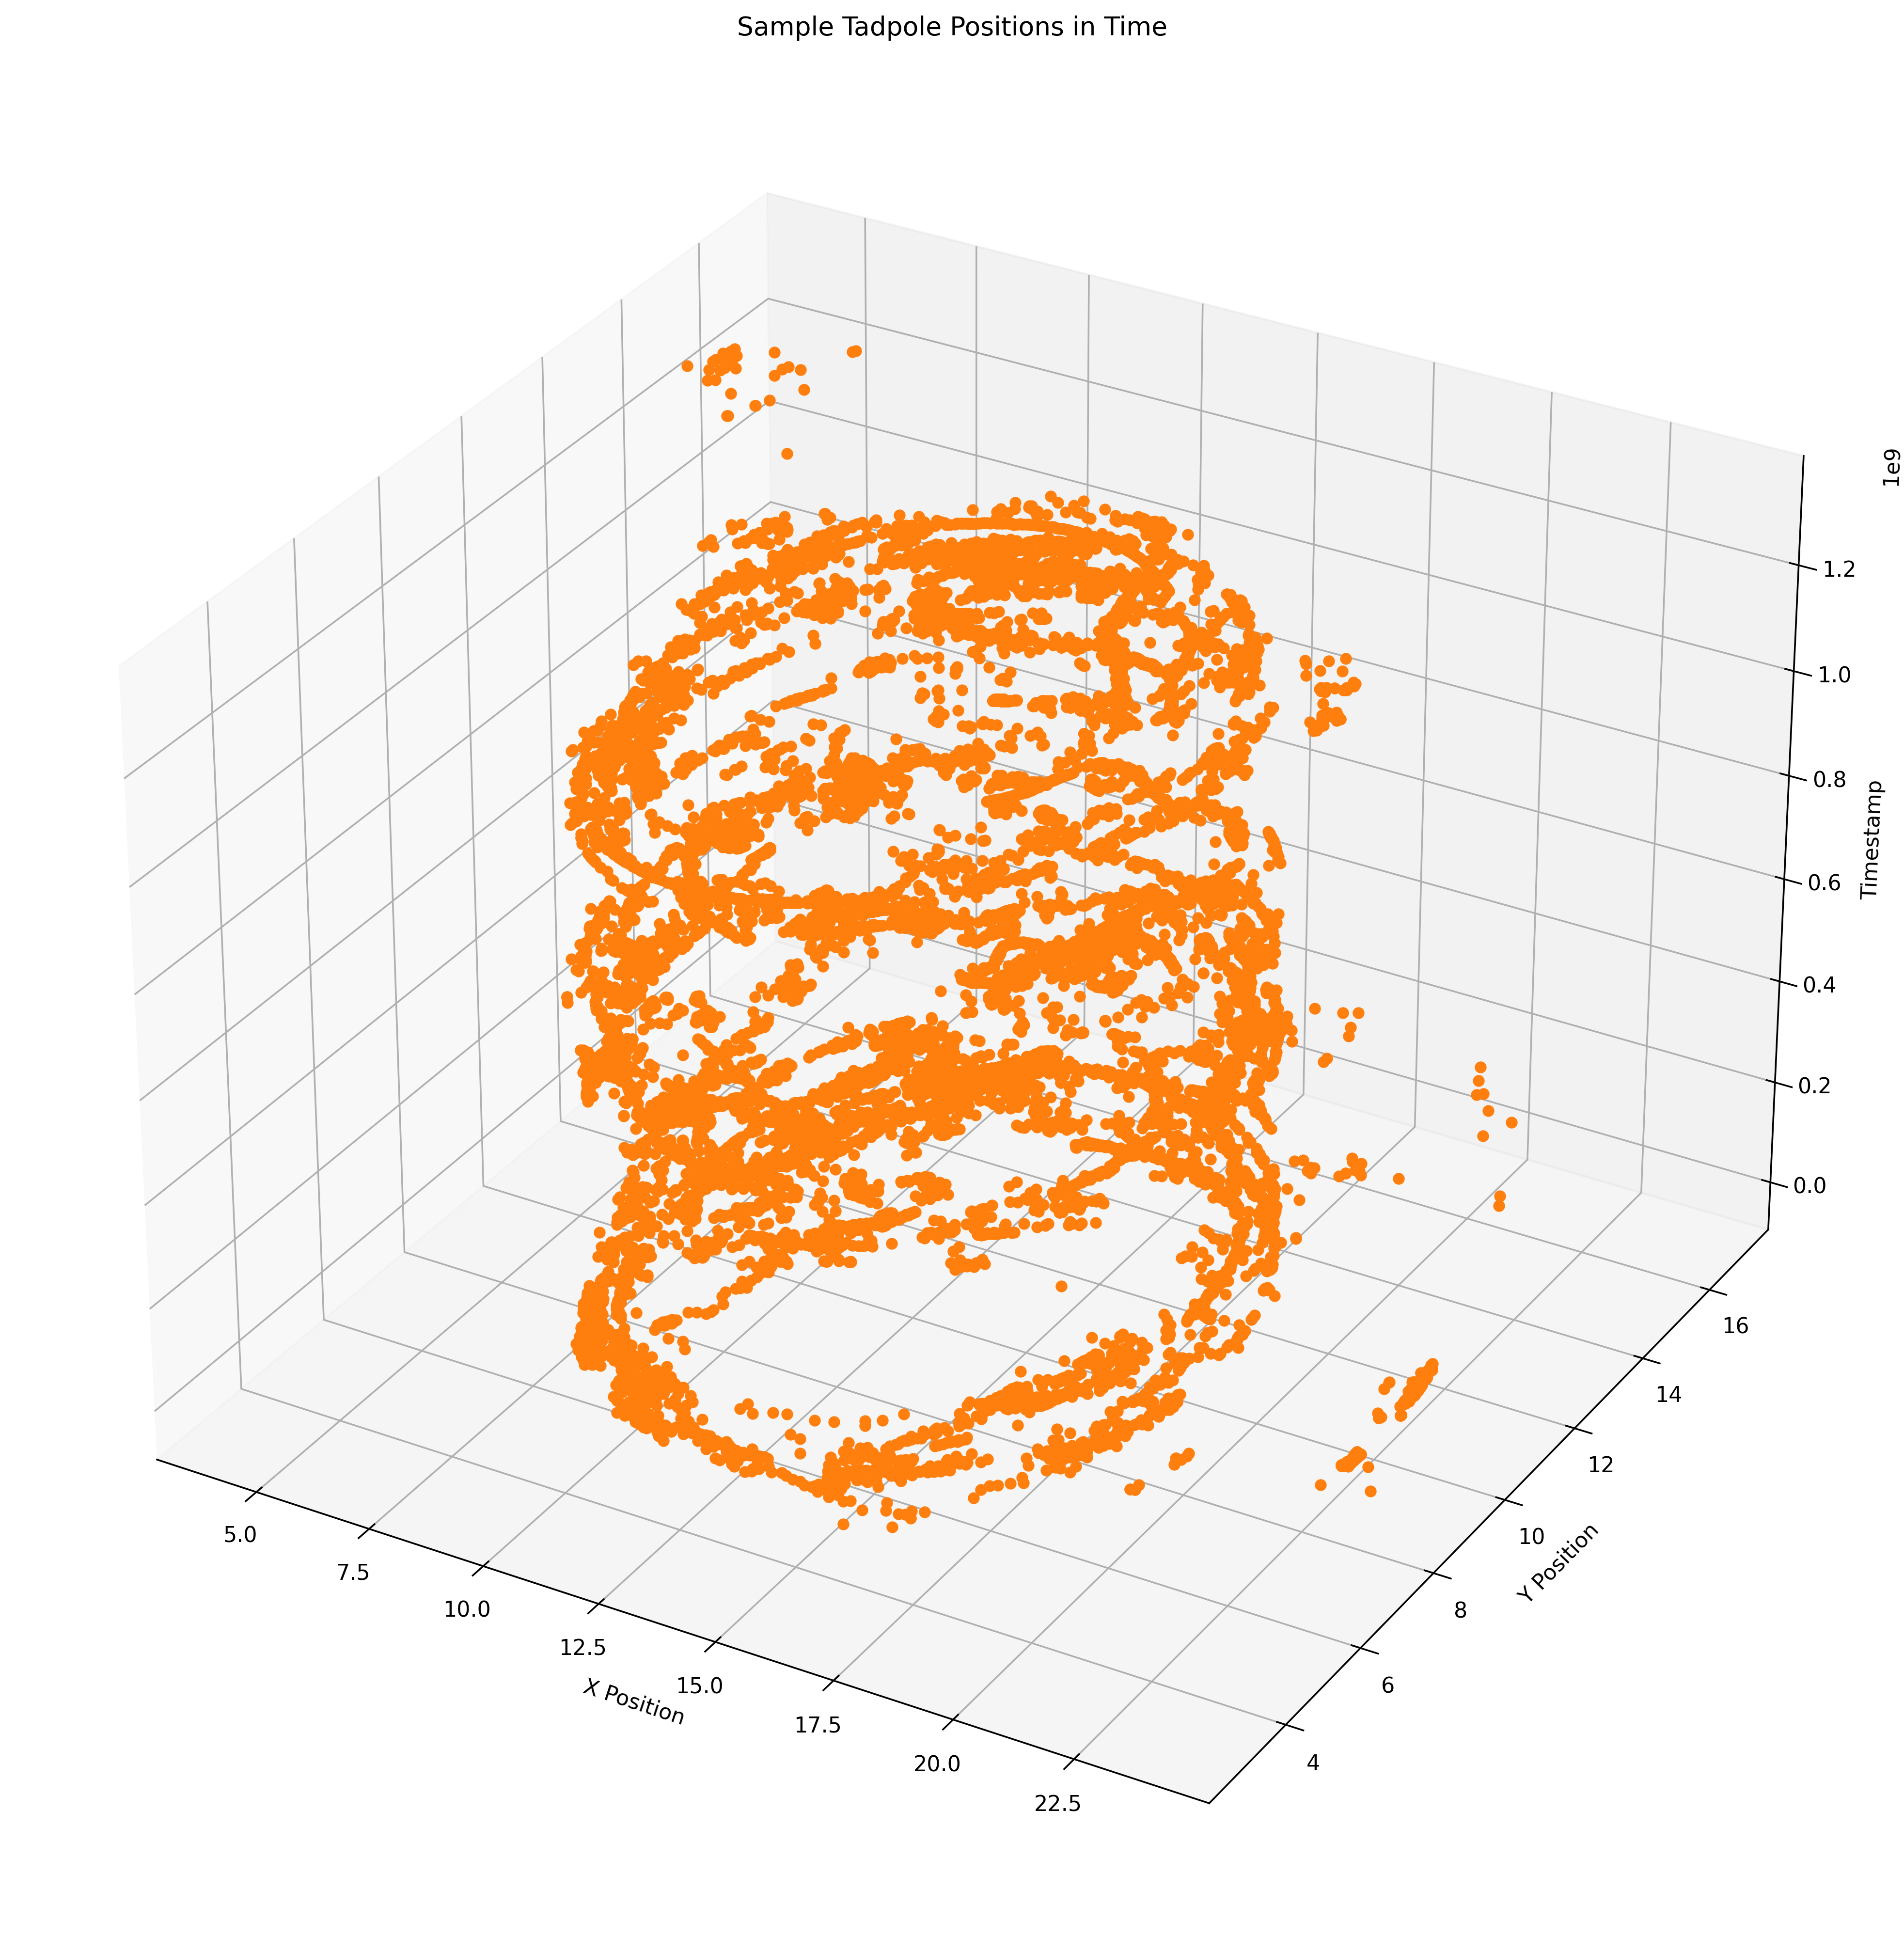

CPU times: user 4min 9s, sys: 1.03 s, total: 4min 10s
Wall time: 4min 10s


In [17]:
%%time
# Build figure
fig = plt.figure(figsize=(16, 16), dpi=320)
ax = fig.add_subplot(projection='3d')

# Plot coordinates for tadpole
for record in sample_position_df.iterrows():
    xs = record[1]['X']
    ys = record[1]['Y']
    zs = record[1]['timestamp']
    ax.scatter(xs, ys, zs, marker='o', c='#ff7f0e')

# Add labels
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Timestamp')

# Add title
plt.title('Sample Tadpole Positions in Time')

# Display
plt.show()

### Plot Coordinates in Time for Multiple Sample Tadpoles for Non-Missing Frames
Here we take a sample of four tadpoles to keep the graph from getting too messy.  Skip this cell if you don't want to wait.  Plotting all coordinates is slow.

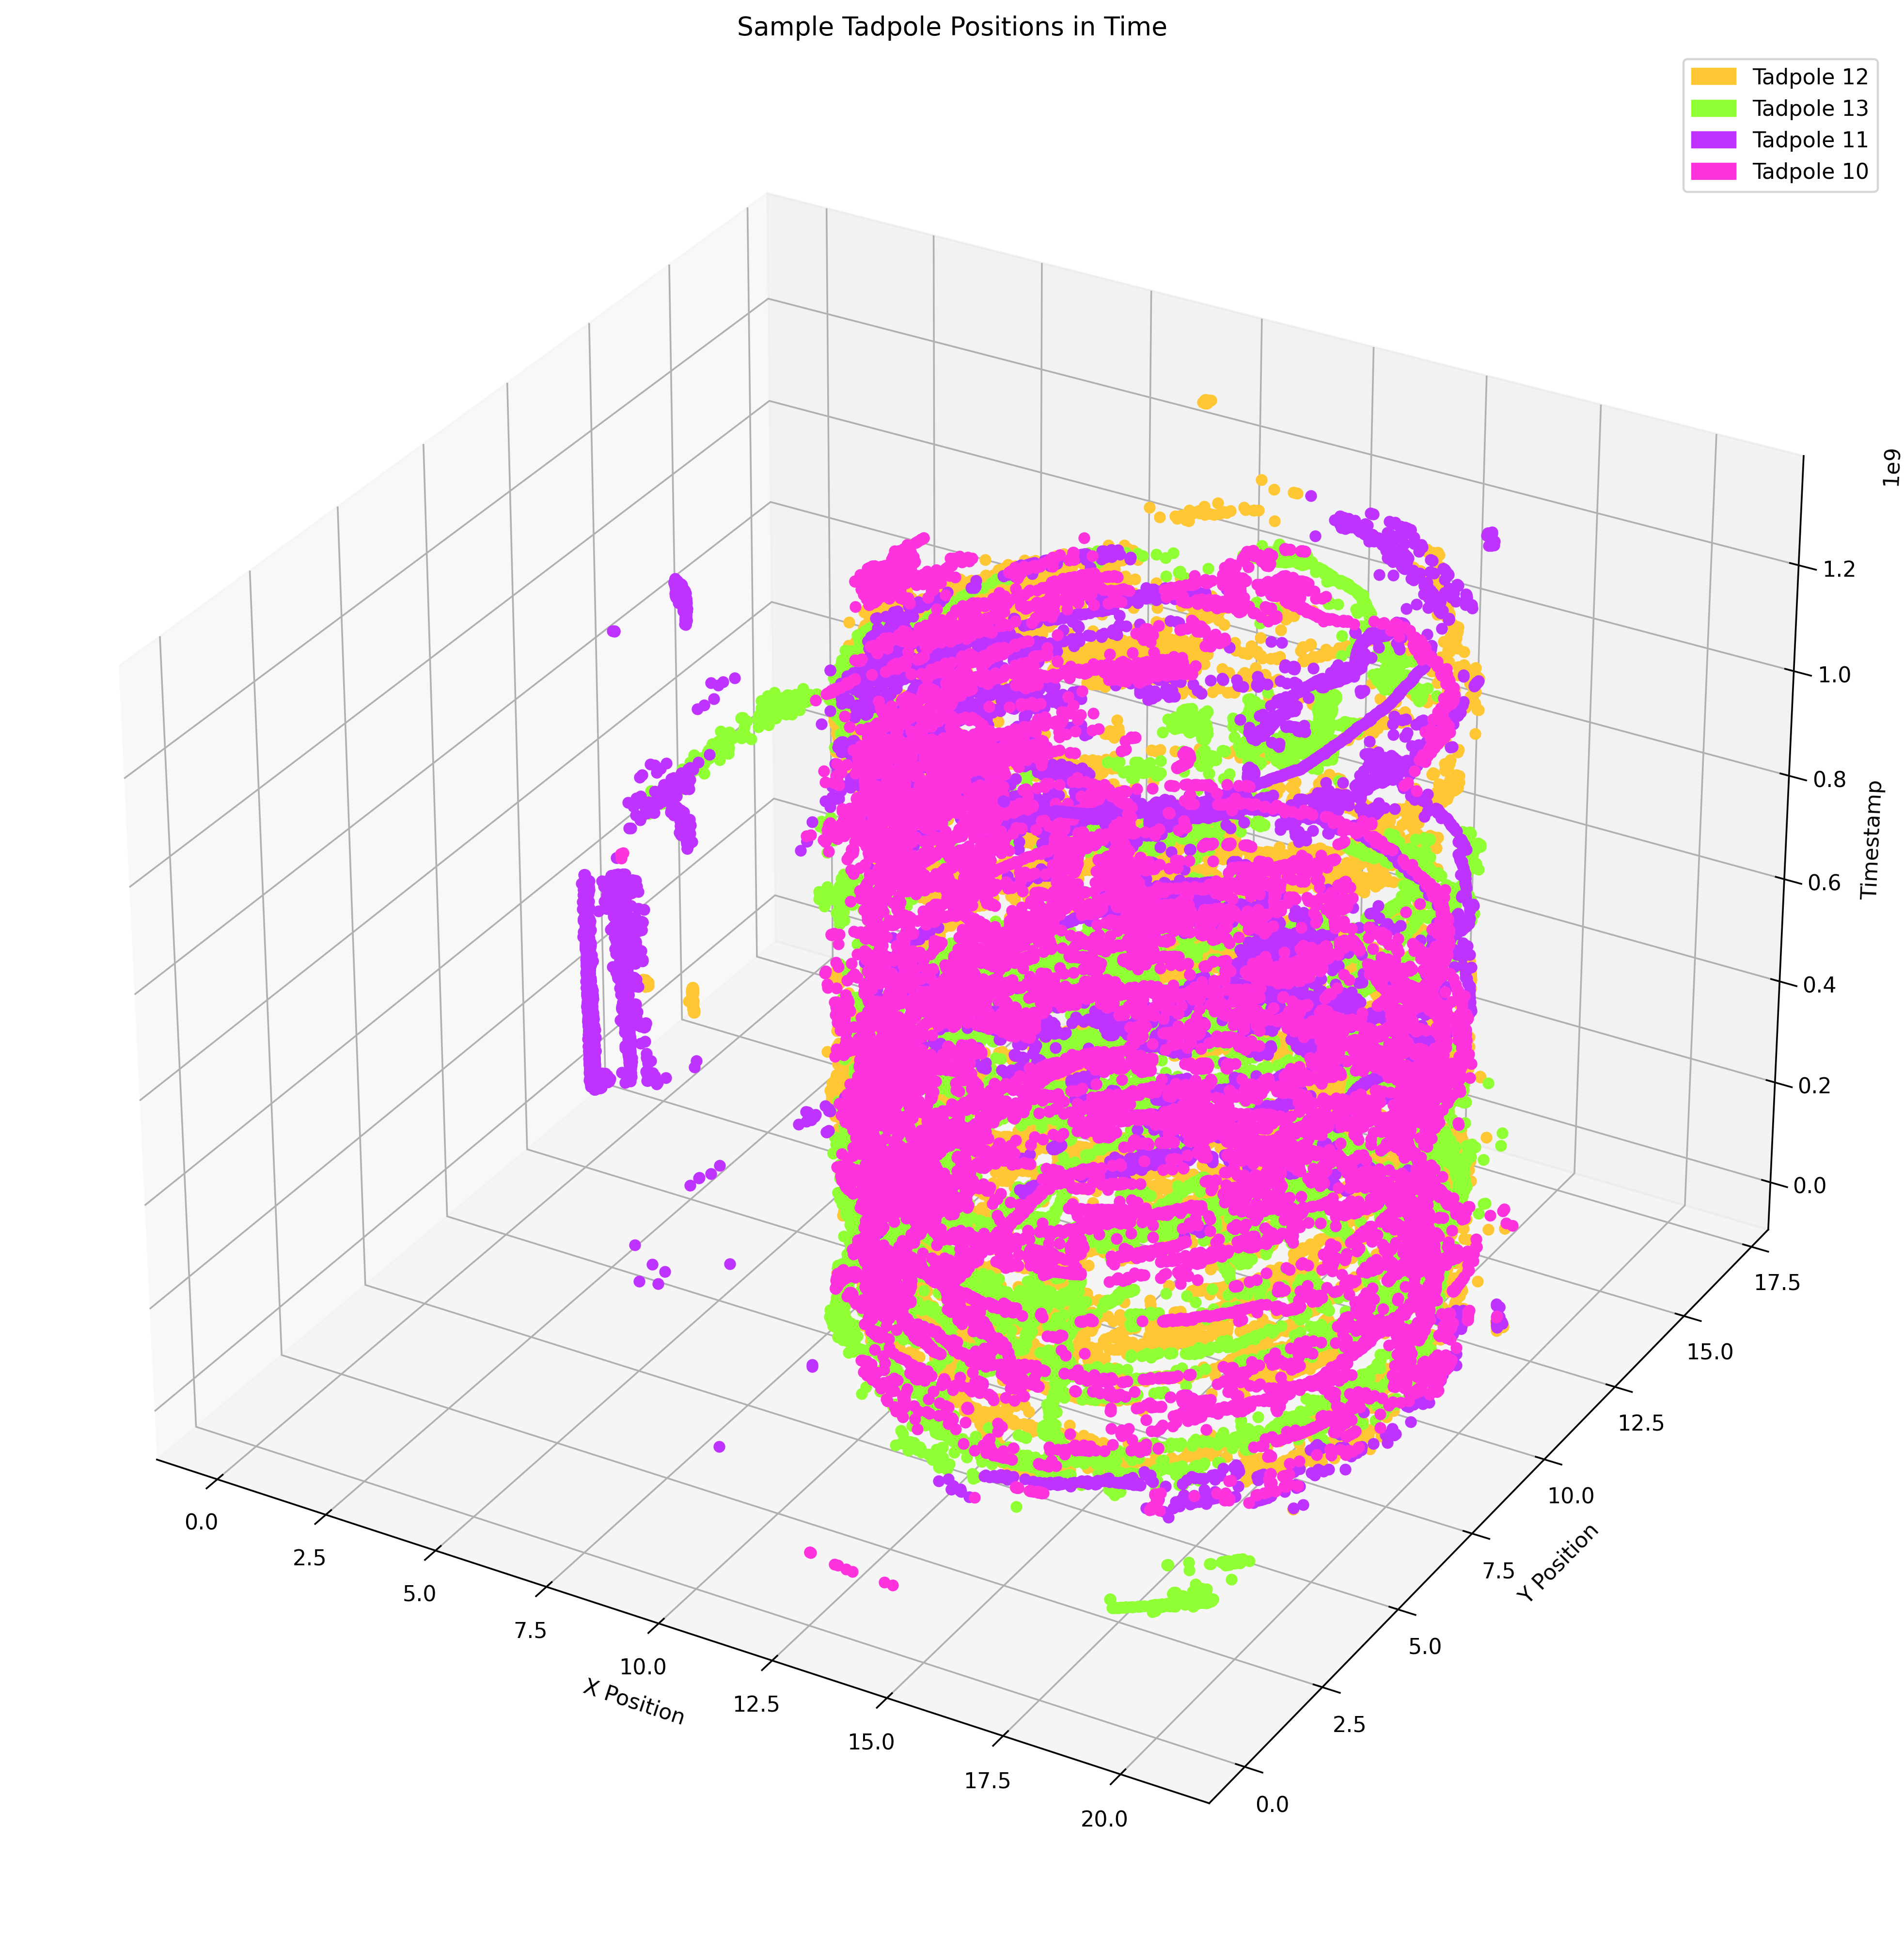

CPU times: user 18min 5s, sys: 4.79 s, total: 18min 10s
Wall time: 18min 12s


In [18]:
%%time
# Build figure
fig = plt.figure(figsize=(16, 16), dpi=320)
ax = fig.add_subplot(projection='3d')

# Iterate through sample tadpoles and colors
names = []
colors = ['#FFC733', '#90FF33', '#BE33FF', '#FF33DD']
for tadpole_file, color in zip(all_tadpole_data_files[0:4], colors):
    
    # Retrieve tadpole name from file
    tadpole_name = 'Tadpole ' + tadpole_file.split('/')[-1].split('tadpole')[-1].split('.')[0]
    names.append(tadpole_name)
    
    # Load tadpole data
    tadpole_data = np.load(tadpole_file)
    
    # Create tadpole dataframe
    tadpole_df = pd.DataFrame({
        'timestamp': tadpole_data['timestamp'],
        'X': tadpole_data['X'],
        'Y': tadpole_data['Y']
    })
    
    # Plot coordinates for tadpole
    for record in tadpole_df.iterrows():
        xs = record[1]['X']
        ys = record[1]['Y']
        zs = record[1]['timestamp']
        ax.scatter(xs, ys, zs, marker='o', c=color)

# Add labels
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Timestamp')

# Add legend
patches = [mpatches.Patch(color=c, label=n) for c, n in zip(colors, names)]
plt.legend(handles=patches)

# Add title
plt.title('Sample Tadpole Positions in Time')

# Display
plt.show()

### Create Dataframe of Locations of All Tadpoles

In [19]:
%%time
tadpole_names = []
last_tadpole_name = None
global_df = pd.DataFrame()
for i, tadpole_file in enumerate(all_tadpole_data_files):
    
    # Retrieve tadpole name from file
    tadpole_name = tadpole_file.split('/')[-1].split('tadpole')[-1].split('.')[0]
    tadpole_names.append(tadpole_name)

    # Load tadpole data
    tadpole_data = np.load(tadpole_file) 
    
    # Create tadpole dataframe
    tadpole_df = pd.DataFrame({
        f'{tadpole_name}_timestamp': tadpole_data['timestamp'],
        f'{tadpole_name}_X': tadpole_data['X'],
        f'{tadpole_name}_Y': tadpole_data['Y']
    })
    
    # Add each individual tadpole dataframe to the global dataframe
    if i == 0:
        global_df = tadpole_df
        last_tadpole_name = tadpole_name
    else:
        global_df = pd.merge(
            global_df,
            tadpole_df,
            left_on=f'{last_tadpole_name}_timestamp',
            right_on=f'{tadpole_name}_timestamp',
            how='left'
        )
        last_tadpole_name = tadpole_name

CPU times: user 622 ms, sys: 40.5 ms, total: 662 ms
Wall time: 1.14 s


### Remove Missing Timestamps
Drop frames where timestamps are missing for at least one tadpole.  Note that this constitutes a very small number of frames by checking the dataframe shapes shown before and after this step.

In [20]:
global_df.shape

(37949, 90)

In [21]:
for tadpole in tadpole_names:
    global_df = global_df[global_df[f'{tadpole_name}_timestamp'].notna()]

In [22]:
global_df.shape

(37935, 90)

### Sync Timestamp Columns
We also check that the timestamps in the global dataframe, after dropping missing timestamps, can be safely merged to a single, global timestamp column.

In [23]:
equal_timestamps = [
    np.all(
        global_df[f'{tadpole_names[i]}_timestamp'] == global_df[f'{tadpole_names[i + 1]}_timestamp']
    ) for i in range(len(tadpole_names) - 1)
]

In [24]:
np.all(equal_timestamps)

True

### Create Global Timestamp
This timestamp is not associated with any one tadpole but represents all tadpoles in the dataset after dropping missing frames.

In [25]:
global_df['timestamp'] = global_df[f'{random.choice(tadpole_names)}_timestamp']

In [26]:
for tadpole_name in tadpole_names:
    global_df = global_df.drop(f'{tadpole_name}_timestamp', axis=1)

### Sort by Timestamp

In [27]:
global_df = global_df.sort_values(by=['timestamp'])

In [28]:
global_df.shape

(37935, 61)

### View Sample of All Tadpole Data

In [29]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(global_df.sample(n=10))

12_X       12_Y       13_X      13_Y       11_X       11_Y  \
27993   5.861268  14.042849  19.030325  1.782589        inf        inf   
1731         inf        inf  13.253405  2.955331        inf        inf   
16075   9.450671   5.260869  10.948931  6.346153  14.133914  11.765184   
15944   8.652959   7.870983  10.474874  5.407706  13.933077  12.137848   
21782  13.493037  10.629842        inf       inf  15.336288   8.190005   
33460  12.102802  11.470650  14.552063  9.384991   7.571717   9.631290   
4700   17.525129   8.138441   9.188155  6.667686   0.219727  10.054894   
26344   5.585432  14.028169  13.643243  3.848517  14.046962   3.100517   
10844  15.491693   3.985826  16.849762  3.929519   0.737625  10.327289   
25292  10.836795   9.002111        inf       inf  19.615534   9.994338   

            10_X       10_Y        9_X        9_Y       28_X       28_Y  \
27993   7.898172  11.377822        inf        inf  10.963362   3.831296   
1731   14.636811  13.577184   0.192458  10.214909        inf        inf   
16075  19.444506   8.100241  19.362211   1.036534  12.410906  10.804579   
15944  19.144899   9.738626  19.248436   0.963597  12.472953  10.920417   
21782  18.873816   7.880790  13.964152   9.602262        inf        inf   
33460  18.646862  10.943922  13.135874   9.763973  12.223242  10.493278   
4700   10.326638  12.822340  14.938572   3.745658  18.093304   5.226891   
26344   5.665457  14.591646  14.422404   7.955532   9.935248   7.451604   
10844        inf        inf   8.148658   9.832078  16.498884  10.557625   
25292   8.628387  11.375522  14.654255  14.547959  18.789064   7.001774   

            14_X       14_Y       15_X       15_Y       29_X       29_Y  \
27993  10.499712   5.674722  14.108745  14.600827  18.016298   5.698581   
1731         inf        inf  14.414772   9.832534        inf        inf   
16075  17.869932  12.445925  14.110364   9.597047        inf        inf   
15944  17.147902  13.179379  14.105151   9.597656  17.583464   5.109085   
21782  11.077683   4.406926  18.583632   8.312023  10.887982  13.915325   
33460  26.299971  15.409991  17.643377   8.207299  18.783901   9.761534   
4700   12.931130  10.225141  15.772009  10.479910        inf        inf   
26344  16.156527  11.124563        inf        inf        inf        inf   
10844  12.057723  13.299549  16.654682   7.759748  12.744737  11.640199   
25292        inf        inf  10.083892  12.914410  13.142814  13.559865   

             8_X        8_Y       17_X       17_Y       16_X       16_Y  \
27993  11.543297   6.280150  18.981466   7.788262  13.306567   7.479918   
1731         inf        inf        inf        inf        inf        inf   
16075  15.913509  12.135282  19.164541   9.784997  17.352745   4.552496   
15944        inf        inf  19.391273   9.796288  18.845938   5.828686   
21782  12.122485   9.922208        inf        inf  17.062473  13.427816   
33460  12.232537   6.877642        inf        inf  13.594208  14.188055   
4700   17.126823  13.020367   7.597706   9.196478  12.735929  10.036998   
26344  19.053877   7.409589  15.496366  11.149078   9.958415  14.700167   
10844  19.224789   7.523329  12.602830  11.122395   8.745736   8.230115   
25292  14.912897   9.735435  19.135294   9.933496   3.378095  11.970890   

             6_X        6_Y       27_X       27_Y       26_X       26_Y  \
27993  18.122147   8.449268  17.807735   0.193318  19.593458   6.560071   
1731         inf        inf  12.482789  10.403550        inf        inf   
16075  14.507473  13.371382   9.338838  10.299277        inf        inf   
15944  15.775950  13.734827  10.813369   7.608080  15.253934   3.408580   
21782  16.503246   7.263993  13.129343   9.813077  16.913042  13.148381   
33460        inf        inf  16.434080   8.931351  14.070558   4.143634   
4700   16.643732  14.007612  19.732569   1.211972   9.761786   5.191509   
26344  13.672514   9.639918  19.465597   2.111421  11.172713  10.496280   
10844  16.652205   3.962436  13.147262  11.3

### Create Tadpole Position Nested Dictionary for Collision Analysis
Keys are tadpoles and values are dictionaries containing X and Y positions for each timestamp from the global dataframe.

In [30]:
# Build empty dict
tadpole2position = {}

# Iterate through dataframe columns ignoring the 0th index which is the timestamp
records = global_df.columns[1:]
for i in range(0, len(records), 3):
    
    # Retrieve name and x, y positions
    tadpole_name = records[i].split('_')[0]
    x = global_df[f'{tadpole_name}_X'].values
    y = global_df[f'{tadpole_name}_Y'].values
    
    # Create dict entry
    tadpole2position[tadpole_name] = {'X': x, 'Y': y}

### Define Function to Determine if Two Positions Constitute a Collision
Consider other ways to handle inf values.

In [31]:
def is_collision(a, b):
    """
    Return True if coordiantes a and b represent a collision,
    otherise return False.
    """
    
    # If one coordinate contains an infinite value
    # don't count this coordinate pair as a collision
    if np.inf in a or np.inf in b:
        return False
    
    # Compute L2 norm (euclidean distance)
    dist = np.linalg.norm(a-b, ord=2)
    
    return dist < COLLISION_THRESHOLD

### Define Function to Compare All Tadpole Positions at a Given Frame to Find Collisions

In [32]:
@ray.remote
def compare_positions_at_frame(frame_idx):
    """
    For a given frame index, compare the position of each tadpole
    to every other tadpole: O(n^2).  Apply logic to skip computations
    we've already run.  Return a list of sets of tadpoles
    which represents the collisions for the frame.
    """
    
    # Track collisions
    collisions = []
    
    # Iterate through tadpoles
    for tadpole_i, data_i in tadpole2position.items():
        
        # Create position vector i
        x_i = data_i['X'][frame_idx]
        y_i = data_i['Y'][frame_idx]
        position_i = np.array([x_i, y_i])
        
        # Compare to every other tadpole
        for tadpole_j, data_j in tadpole2position.items():
            
            # Skip comparing to oneself
            if tadpole_i == tadpole_j:
                continue
            
            # Use a set to represent tadpole pairs
            # so that the order of tadpoles i and j doesn't matter
            pair = set((tadpole_i, tadpole_j))
            
            # If we have already run is_collision for this pair,
            # skip to the next pair
            if pair in collisions:
                continue
            
            # Create position vector j
            x_j = data_j['X'][frame_idx]
            y_j = data_j['Y'][frame_idx]
            position_j = np.array([x_j, y_j])
            
            # Check if this is a collision
            if is_collision(position_i, position_j):
                
                # Save the pair that collided
                collisions.append(pair)
                
    return collisions

### Run Parallel Comparisons for All Frames
Ray uses multi-processing to apply the `compare_records` functions to many frames at once.

In [33]:
ray.init()

/opt/anaconda3/lib/python3.8/site-packages/ray/_private/services.py:238: UserWarning: Not all Ray Dashboard dependencies were found. To use the dashboard please install Ray using `pip install ray[default]`. To disable this message, set RAY_DISABLE_IMPORT_WARNING env var to '1'.
  warnings.warn(warning_message)


{'node_ip_address': '10.97.205.142',
 'raylet_ip_address': '10.97.205.142',
 'redis_address': '10.97.205.142:6379',
 'object_store_address': '/tmp/ray/session_2021-09-29_21-31-50_497196_54456/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-09-29_21-31-50_497196_54456/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2021-09-29_21-31-50_497196_54456',
 'metrics_export_port': 61591,
 'node_id': '15989cdc84cc7e1b6d0f6360a2ea8da24fc1d6971d16676fe78dce3f'}

In [34]:
timestamps = global_df['timestamp'].values

In [35]:
%%time
all_collisions = ray.get([compare_positions_at_frame.remote(frame_idx) for frame_idx in range(len(timestamps))])

CPU times: user 13.8 s, sys: 5.35 s, total: 19.2 s
Wall time: 58.2 s


### Create Collisions Dataframe
To check for pairwise collisions at a given frame, index the collisions dataframe and view the pairs that collided.  This dataframe is sorted by the timestamp.

In [36]:
collision_df = pd.DataFrame({
    'timestamp': timestamps,
    'collisions': all_collisions
}).sort_values(by=['timestamp'])

### Add a Column to Explicity Indicate which Frames Contain Collisions

In [37]:
collision_df['has_collision'] = collision_df['collisions'].apply(lambda x: 1 if len(x) > 0 else 0)

### View Random Sample of Collisions Dataframe

In [38]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(collision_df.sample(n=10))

timestamp collisions  has_collision
34729  1.197552e+09         []              0
33680  1.161379e+09         []              0
11124  3.835862e+08         []              0
35713  1.231483e+09         []              0
1676   5.779310e+07         []              0
11718  4.040690e+08         []              0
33925  1.169828e+09         []              0
23902  8.242069e+08         []              0
11565  3.987931e+08         []              0
13412  4.624828e+08         []              0

### Filter for and View a Random Sample of Collisions Dataframe with Known Collisions

In [39]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(collision_df[collision_df['has_collision'] == 1].sample(n=10))

timestamp  collisions  has_collision
6102   210413792.0  [{14, 10}]              1
12296  424000000.0  [{25, 12}]              1
10317  355758624.0    [{8, 3}]              1
25137  866793088.0    [{4, 2}]              1
6789   234103456.0   [{4, 16}]              1
25128  866482752.0    [{4, 2}]              1
18862  650413824.0   [{12, 6}]              1
24825  856034496.0   [{14, 8}]              1
25126  866413824.0    [{4, 2}]              1
26139  901344832.0    [{3, 6}]              1

### Compute Total Collisions and Collision Rate

In [40]:
num_frames = collision_df.shape[0]

In [41]:
num_frames

37935

In [42]:
num_collisions = collision_df[collision_df['has_collision'] == 1].shape[0]

In [43]:
num_collisions

166

In [44]:
collision_rate = round(num_collisions / num_frames, 3)

In [45]:
collision_rate

0.004

### Plot All Collisions

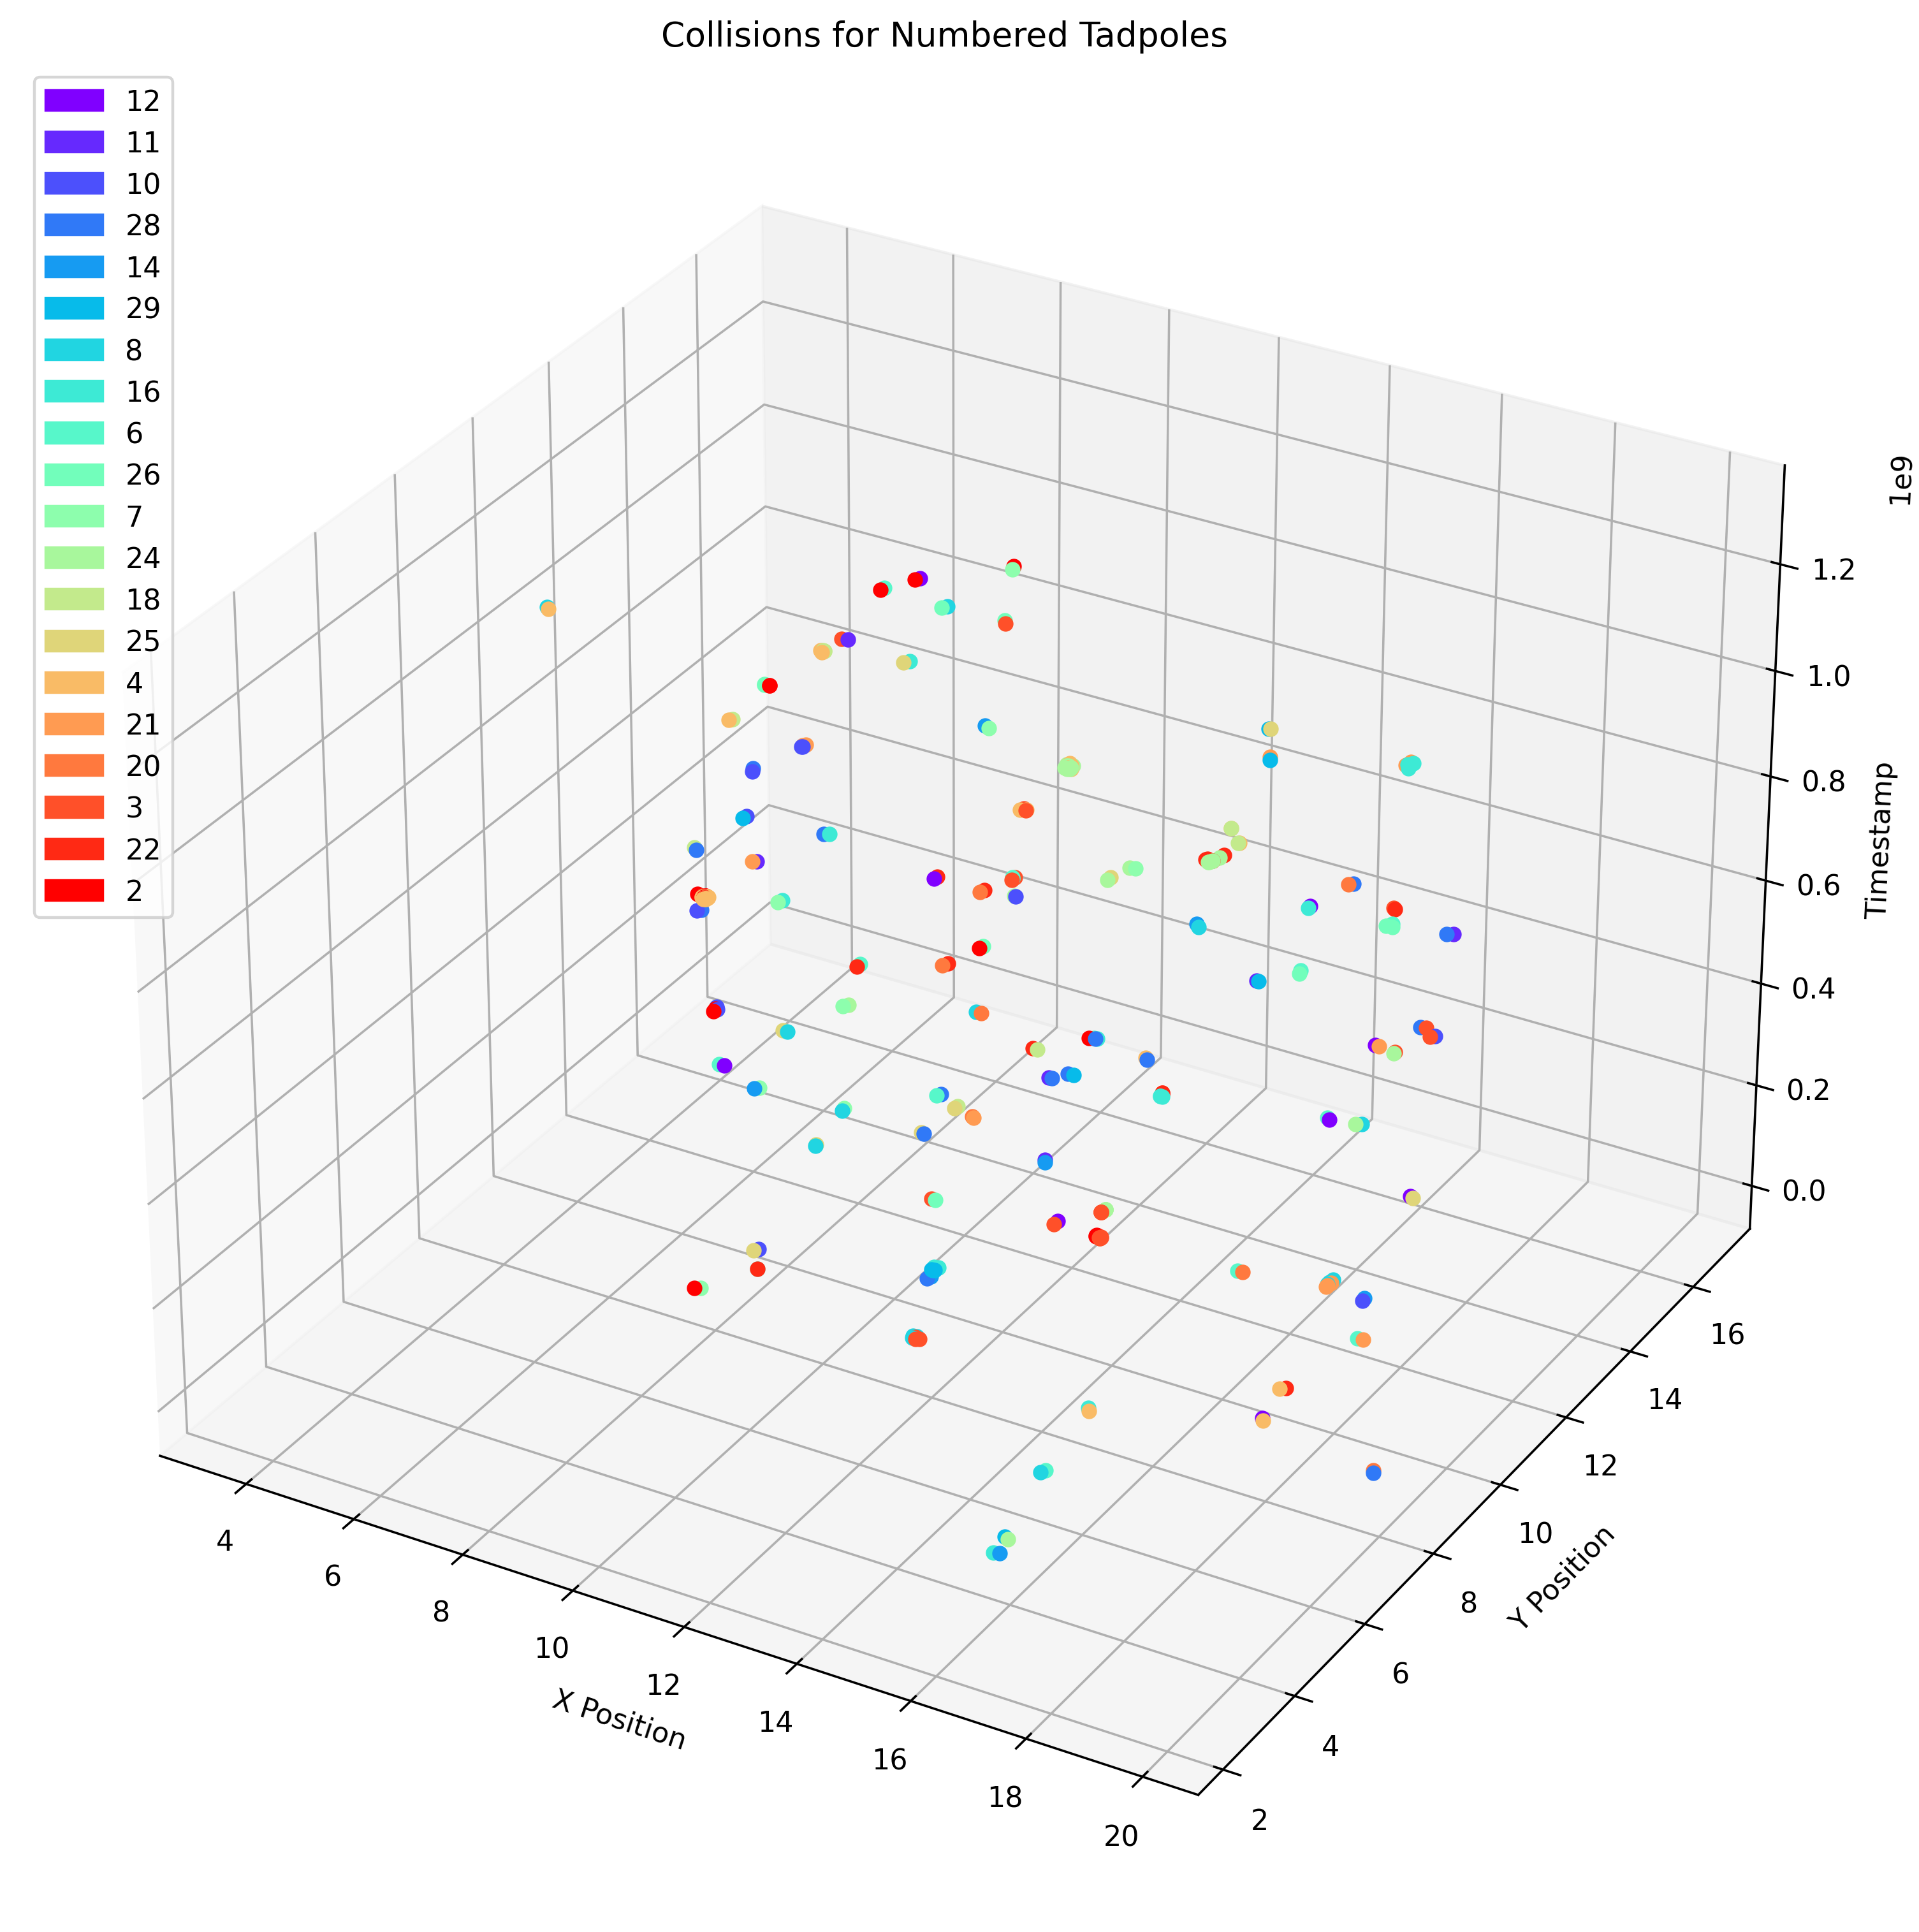

In [46]:
# Build figure
fig = plt.figure(figsize=(12, 12), dpi=320)
ax = fig.add_subplot(projection='3d')

# Build colors and color map
colors = plt.cm.rainbow(np.linspace(0, 1, len(tadpole2position.keys())))
tadpole2color = {tadpole: color for tadpole, color in zip(list(tadpole2position.keys()), colors)}

# Iterate through collisions
for row in collision_df[collision_df['has_collision'] == 1].iterrows():
    
    # Retrieve positions at timestamp from global dataframe
    positions = global_df[global_df['timestamp'] == row[1]['timestamp']]
    
    # Iterate through collisions, as more than one tadpole
    # could have collided in the given frame
    for collision in row[1]['collisions']:
        
        # Retrieve tadpoles from collision set
        tadpole_a = list(collision)[0]
        tadpole_b = list(collision)[1]
        
        # Retrieve tadpole coordinates
        tadpole_a_x = positions[f'{tadpole_a}_X'].values[0]
        tadpole_a_y = positions[f'{tadpole_a}_Y'].values[0]
        tadpole_b_x = positions[f'{tadpole_b}_X'].values[0]
        tadpole_b_y = positions[f'{tadpole_b}_Y'].values[0]
    
        # Plot coordinates for tadpoles
        ax.scatter(
            tadpole_a_x,
            tadpole_a_y,
            row[1]['timestamp'],
            marker='o',
            c=tadpole2color[tadpole_a].reshape(1,-1)
        )
        ax.scatter(
            tadpole_b_x,
            tadpole_b_y,
            row[1]['timestamp'],
            marker='o',
            c=tadpole2color[tadpole_b].reshape(1,-1)
        )

# Add labels
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Timestamp')

# Add legend
patches = [mpatches.Patch(color=c, label=l) for l, c in tadpole2color.items()]
plt.legend(handles=patches, loc="upper left")

# Add title
plt.title('Collisions for Numbered Tadpoles')

# Display
plt.show()

### Create Timestamp for Saving Records

In [47]:
timestr = time.strftime("%Y%m%d-%H%M%S")

### Save Tadpole Location Dataframe

In [48]:
if not os.path.exists('datasets'):
    os.makedirs('datasets')

In [49]:
global_df.to_csv(f'datasets/tadpole_locations_{timestr}.csv', index=False)

### Save Pairwise Collision Dataframe

In [50]:
collision_df.to_csv(f'datasets/pairwise_tadpole_collisions_{timestr}.csv', index=False)